# Policy gradients


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.7248183067276615 -2.892738550275059
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [25]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    return states, actions, targetQs, reward

In [26]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [27]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [38]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    Qs_logits += discriminator(actions=tf.nn.softmax(actions_logits), hidden_size=hidden_size, states=states, 
                               reuse=True)
    Qs_logits += discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True)
    Qs_logits /= 3
    d_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits,
                                                                    labels=reward*tf.ones_like(Qs_logits)))
#     g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits,
#                                                                     labels=tf.ones_like(Qs_logits)))
    
    g_loss = tf.reduce_mean(neg_log_prob_actions * targetQs)

    return actions_logits, Qs_logits, g_loss, d_loss

In [39]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [40]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, # model input
            targetQs=self.targetQs, reward=self.reward) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [41]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(13, 4) actions:(13,)
action size:2


In [42]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [43]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [44]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [45]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

# Now train with experiences
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(1111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            Q_logits = sess.run(model.Qs_logits, feed_dict={model.states: np.reshape(state, [1, -1]), 
                                                            model.actions: np.array([action])})
            batch.append([state, action, Q_logits])
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                rate = total_reward/200 # success is 200 points
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        g_loss, d_loss, _, _ = sess.run([model.g_loss, model.d_loss, model.g_opt, model.d_opt],
                                        feed_dict = {model.states: states, 
                                                     model.actions: actions,
                                                     model.reward: rate,
                                                     model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 200:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:39.0000 gloss:-0.0268 dloss:0.6815
Episode:1 meanR:24.5000 gloss:-0.1053 dloss:0.6252
Episode:2 meanR:39.0000 gloss:-0.0635 dloss:0.6794
Episode:3 meanR:35.7500 gloss:-0.0864 dloss:0.6482
Episode:4 meanR:33.8000 gloss:-0.1009 dloss:0.6411
Episode:5 meanR:33.3333 gloss:-0.1259 dloss:0.6338
Episode:6 meanR:31.7143 gloss:-0.1531 dloss:0.6123
Episode:7 meanR:29.6250 gloss:-0.1858 dloss:0.5874
Episode:8 meanR:27.3333 gloss:-0.2265 dloss:0.5561
Episode:9 meanR:25.7000 gloss:-0.2892 dloss:0.5283
Episode:10 meanR:24.0909 gloss:-0.3030 dloss:0.5117
Episode:11 meanR:23.0000 gloss:-0.3846 dloss:0.4840
Episode:12 meanR:21.9231 gloss:-0.4071 dloss:0.4681
Episode:13 meanR:21.5714 gloss:-0.4102 dloss:0.4906
Episode:14 meanR:21.8667 gloss:-0.4268 dloss:0.5119
Episode:15 meanR:22.7500 gloss:-0.4396 dloss:0.5400
Episode:16 meanR:22.8235 gloss:-0.4991 dloss:0.4835
Episode:17 meanR:23.2222 gloss:-0.5159 dloss:0.5011
Episode:18 meanR:23.0000 gloss:-0.5956 dloss:0.4358
Episode:19 meanR:24.10

Episode:158 meanR:33.8000 gloss:-0.9851 dloss:0.3517
Episode:159 meanR:33.6800 gloss:-1.0203 dloss:0.3846
Episode:160 meanR:33.5600 gloss:-1.0343 dloss:0.3231
Episode:161 meanR:33.4500 gloss:-1.0868 dloss:0.3160
Episode:162 meanR:33.3700 gloss:-1.1099 dloss:0.3376
Episode:163 meanR:33.3100 gloss:-1.1597 dloss:0.2749
Episode:164 meanR:33.2200 gloss:-1.1782 dloss:0.2810
Episode:165 meanR:33.1600 gloss:-1.2225 dloss:0.2855
Episode:166 meanR:33.0800 gloss:-1.2974 dloss:0.2431
Episode:167 meanR:33.0600 gloss:-1.3819 dloss:0.2450
Episode:168 meanR:32.9800 gloss:-1.3645 dloss:0.2377
Episode:169 meanR:32.9500 gloss:-1.4350 dloss:0.2240
Episode:170 meanR:32.9500 gloss:-1.4962 dloss:0.2609
Episode:171 meanR:32.9200 gloss:-1.5249 dloss:0.2384
Episode:172 meanR:32.9000 gloss:-1.5938 dloss:0.2351
Episode:173 meanR:32.9100 gloss:-1.6162 dloss:0.2578
Episode:174 meanR:32.9800 gloss:-1.2542 dloss:0.3363
Episode:175 meanR:33.4000 gloss:-1.1522 dloss:0.6153
Episode:176 meanR:35.8700 gloss:-1.0727 dloss:

Episode:314 meanR:33.6200 gloss:-0.8385 dloss:0.5243
Episode:315 meanR:32.5400 gloss:-0.9123 dloss:0.4304
Episode:316 meanR:31.7900 gloss:-0.9004 dloss:0.5424
Episode:317 meanR:31.1400 gloss:-0.9077 dloss:0.5890
Episode:318 meanR:30.5300 gloss:-0.8638 dloss:0.6423
Episode:319 meanR:30.4400 gloss:-0.8376 dloss:0.8634
Episode:320 meanR:30.3600 gloss:-0.8076 dloss:0.8050
Episode:321 meanR:29.7900 gloss:-0.9092 dloss:0.5560
Episode:322 meanR:29.1600 gloss:-0.9103 dloss:0.5230
Episode:323 meanR:28.7500 gloss:-0.8965 dloss:0.4772
Episode:324 meanR:28.3400 gloss:-0.8630 dloss:0.4918
Episode:325 meanR:28.1400 gloss:-0.8836 dloss:0.4460
Episode:326 meanR:27.8300 gloss:-0.8959 dloss:0.4123
Episode:327 meanR:27.9500 gloss:-0.8754 dloss:0.4537
Episode:328 meanR:28.0400 gloss:-0.8800 dloss:0.4535
Episode:329 meanR:28.1300 gloss:-0.9286 dloss:0.3886
Episode:330 meanR:28.1900 gloss:-0.9362 dloss:0.3877
Episode:331 meanR:28.2800 gloss:-0.9148 dloss:0.4175
Episode:332 meanR:28.3600 gloss:-0.9603 dloss:

Episode:472 meanR:36.5000 gloss:-0.8809 dloss:1.2029
Episode:473 meanR:36.6500 gloss:-0.7894 dloss:0.5412
Episode:474 meanR:36.7300 gloss:-0.8112 dloss:0.4595
Episode:475 meanR:36.7100 gloss:-0.8603 dloss:0.3546
Episode:476 meanR:36.4800 gloss:-0.9123 dloss:0.3442
Episode:477 meanR:36.3600 gloss:-0.8771 dloss:0.3706
Episode:478 meanR:36.2400 gloss:-0.8359 dloss:0.4084
Episode:479 meanR:36.1900 gloss:-0.9485 dloss:0.3243
Episode:480 meanR:36.1400 gloss:-0.9435 dloss:0.3258
Episode:481 meanR:35.7900 gloss:-0.9782 dloss:0.3135
Episode:482 meanR:35.7700 gloss:-1.0169 dloss:0.3074
Episode:483 meanR:35.3500 gloss:-1.0779 dloss:0.2821
Episode:484 meanR:34.9600 gloss:-1.0034 dloss:0.3317
Episode:485 meanR:34.9600 gloss:-1.1427 dloss:0.2980
Episode:486 meanR:34.6900 gloss:-1.0212 dloss:0.3585
Episode:487 meanR:34.6000 gloss:-1.1411 dloss:0.3061
Episode:488 meanR:34.6100 gloss:-1.1533 dloss:0.2854
Episode:489 meanR:34.3300 gloss:-1.1400 dloss:0.3212
Episode:490 meanR:34.5000 gloss:-1.0700 dloss:

Episode:633 meanR:44.6300 gloss:-1.1936 dloss:0.3726
Episode:634 meanR:44.7400 gloss:-1.1473 dloss:0.3854
Episode:635 meanR:44.9000 gloss:-1.1483 dloss:0.3923
Episode:636 meanR:45.0300 gloss:-1.1370 dloss:0.4056
Episode:637 meanR:45.0700 gloss:-1.2902 dloss:0.3557
Episode:638 meanR:45.1400 gloss:-1.2660 dloss:0.3835
Episode:639 meanR:45.4200 gloss:-1.1016 dloss:0.5114
Episode:640 meanR:45.0300 gloss:-1.1610 dloss:0.4261
Episode:641 meanR:43.7900 gloss:-1.2024 dloss:0.3984
Episode:642 meanR:43.1900 gloss:-1.4149 dloss:0.3162
Episode:643 meanR:43.0500 gloss:-1.1668 dloss:0.5623
Episode:644 meanR:43.4700 gloss:-1.1797 dloss:0.7981
Episode:645 meanR:44.0400 gloss:-0.7477 dloss:0.7526
Episode:646 meanR:44.5900 gloss:-0.7305 dloss:0.7065
Episode:647 meanR:45.0500 gloss:-0.7621 dloss:0.6843
Episode:648 meanR:45.6400 gloss:-0.7129 dloss:0.6806
Episode:649 meanR:46.3100 gloss:-0.7292 dloss:0.7567
Episode:650 meanR:46.7800 gloss:-0.7454 dloss:0.6405
Episode:651 meanR:47.3000 gloss:-0.8192 dloss:

Episode:790 meanR:60.0500 gloss:-0.5481 dloss:0.4687
Episode:791 meanR:59.9800 gloss:-0.6216 dloss:0.4310
Episode:792 meanR:59.9000 gloss:-0.8139 dloss:0.4035
Episode:793 meanR:59.8700 gloss:-0.6341 dloss:0.4707
Episode:794 meanR:59.7600 gloss:-0.7295 dloss:0.4043
Episode:795 meanR:59.7300 gloss:-0.7054 dloss:0.4089
Episode:796 meanR:59.6800 gloss:-0.7805 dloss:0.3907
Episode:797 meanR:59.5800 gloss:-0.7786 dloss:0.3858
Episode:798 meanR:59.6500 gloss:-0.6380 dloss:0.4672
Episode:799 meanR:59.7900 gloss:-0.6312 dloss:0.4886
Episode:800 meanR:59.9700 gloss:-0.6085 dloss:0.5120
Episode:801 meanR:60.2400 gloss:-0.5167 dloss:0.5485
Episode:802 meanR:60.4200 gloss:-0.6088 dloss:0.5038
Episode:803 meanR:60.6600 gloss:-0.6451 dloss:0.5158
Episode:804 meanR:60.8700 gloss:-0.6452 dloss:0.5040
Episode:805 meanR:61.1200 gloss:-0.6374 dloss:0.5363
Episode:806 meanR:61.2900 gloss:-0.8156 dloss:0.4704
Episode:807 meanR:61.2800 gloss:-0.9339 dloss:0.4200
Episode:808 meanR:61.2200 gloss:-0.9865 dloss:

Episode:946 meanR:95.3900 gloss:0.0766 dloss:0.7267
Episode:947 meanR:95.7600 gloss:0.0446 dloss:0.7114
Episode:948 meanR:96.0500 gloss:0.0496 dloss:0.7162
Episode:949 meanR:95.3700 gloss:0.0001 dloss:0.6948
Episode:950 meanR:94.4500 gloss:0.0318 dloss:0.7081
Episode:951 meanR:94.1600 gloss:0.0154 dloss:0.7003
Episode:952 meanR:94.4100 gloss:-0.0043 dloss:0.6924
Episode:953 meanR:94.5900 gloss:-0.0012 dloss:0.6933
Episode:954 meanR:94.9000 gloss:-0.0322 dloss:0.6817
Episode:955 meanR:95.2000 gloss:-0.0365 dloss:0.6788
Episode:956 meanR:95.4900 gloss:-0.0337 dloss:0.6794
Episode:957 meanR:95.6800 gloss:-0.0349 dloss:0.6759
Episode:958 meanR:95.7900 gloss:-0.0445 dloss:0.6714
Episode:959 meanR:95.6700 gloss:-0.0587 dloss:0.6655
Episode:960 meanR:95.8000 gloss:-0.0837 dloss:0.6549
Episode:961 meanR:94.3500 gloss:-0.1007 dloss:0.6480
Episode:962 meanR:93.6700 gloss:-0.1010 dloss:0.6420
Episode:963 meanR:92.9300 gloss:-0.1267 dloss:0.6264
Episode:964 meanR:92.4300 gloss:-0.1298 dloss:0.6271

Episode:1099 meanR:33.5700 gloss:-1.3061 dloss:0.2912
Episode:1100 meanR:32.9800 gloss:-1.4327 dloss:0.2965
Episode:1101 meanR:33.4900 gloss:-0.7469 dloss:0.7972
Episode:1102 meanR:33.3200 gloss:-0.8851 dloss:0.4458
Episode:1103 meanR:33.3800 gloss:-0.7673 dloss:0.4850
Episode:1104 meanR:33.5300 gloss:-0.7337 dloss:0.5413
Episode:1105 meanR:33.7200 gloss:-0.7613 dloss:0.5368
Episode:1106 meanR:33.8100 gloss:-0.7627 dloss:0.4529
Episode:1107 meanR:33.9400 gloss:-0.7245 dloss:0.5206
Episode:1108 meanR:34.7700 gloss:-0.6754 dloss:0.8300
Episode:1109 meanR:35.3400 gloss:-0.6703 dloss:0.7368
Episode:1110 meanR:36.3300 gloss:-0.6477 dloss:0.9055


# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

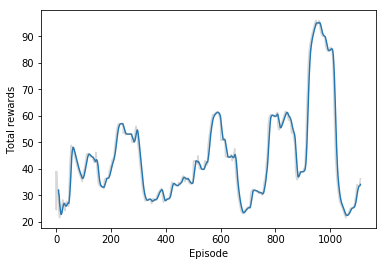

In [47]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

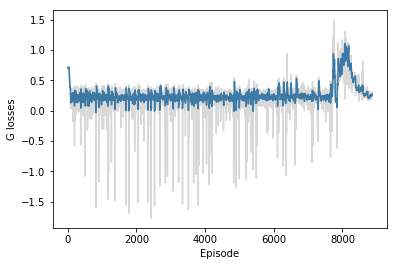

In [26]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

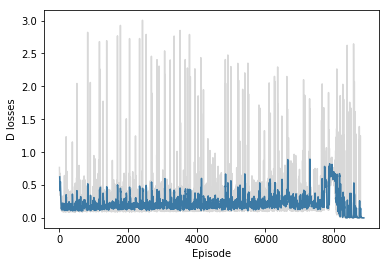

In [27]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [28]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        if total_reward == 500:
            break
                
# Closing the env
env.close()

/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model2.ckpt
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.